#QUORA INSINCERE QUESTION

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#/content/drive/My Drive/quora-insincere-questions-classification.zip
!unzip "/content/drive/My Drive/quora-insincere-questions-classification.zip"

Archive:  /content/drive/My Drive/quora-insincere-questions-classification.zip
  inflating: train.csv               
  inflating: embeddings.zip          
  inflating: sample_submission.csv   
  inflating: test.csv                


In [0]:
!unzip "/content/embeddings.zip"

Archive:  /content/embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  


# Initialization

### Imports

In [0]:
import re
import gc
import os
import time
import random
import operator
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
#tqdm.pandas()

from nltk import word_tokenize
from collections import Counter
from sklearn.utils import shuffle
from tqdm import tqdm_notebook as tqdm
from nltk.tokenize import TweetTokenizer
from multiprocessing import Pool, cpu_count
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold

import torch
import torch.nn as nn
import torch.utils.data

import psutil
import multiprocessing
# import markovify as mk

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Seeding
- For reproductibility

In [0]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    tf.set_random_seed(seed)

In [0]:
seed = 5583
seed_everything(seed)

begin = time.time()
sns.set_style('whitegrid')

### Embeddings paths

In [0]:
GLOVE = "/content/glove.840B.300d/glove.840B.300d.txt"
PARAGRAM = "/content/paragram_300_sl999/paragram_300_sl999.txt"
FASTTEXT = "/content/wiki-news-300d-1M/wiki-news-300d-1M.vec"

',' array([-0.082752 ,  0.67204  , -0.14987  , -0.064983 ,  0.056491 ,
         0.40228  ,  0.0027747, -0.3311   , -0.30691  ,  2.0817 ...

'.' array([0.031819 ,  0.013643 ,  0.30265  ,  0.0071297, -0.5819   ,
        -0.2774   , -0.050821 , -0.1918   , -0.37846  , -0.06589 ....
 

# Text Data

## Loading

In [29]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


## Features
> Features are taken from one of last year's Jigsaw competiton top scoring kernels

- **Toxic word ratio :** The proportion of words in the sentence that are in a list of words labelled as toxic
- **Total length :** Length of the sentence as a string
- **Unique word ratio :** Proportion of words in the sentence that appear only once
- **Average word frequency :** Frequency of the words in the sentence in the overall corpus


### Toxic word ratio

this are the toxic words, we will count number of toxic words in a question for using it as a feature

In [30]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Converting all the words in the question small letters,then checking for toxic words to  count them and finally using the ratio of (count_of_toxic_words)/(count_of_all_words)

In [0]:
def toxic_words_ratio(text):
    toxic_words = ['4r5e', '5h1t', '5hit', 'a55', 'anal', 'anus', 'ar5e', 'arrse', 'arse', 'ass', 'ass-fucker', 'asses', 'assfucker', 'assfukka', 'asshole', 'assholes', 'asswhole', 'a_s_s', 'b!tch', 'b00bs', 'b17ch', 'b1tch', 'ballbag', 'balls', 'ballsack', 'bastard', 'beastial', 'beastiality', 'bellend', 'bestial', 'bestiality', 'bi+ch', 'biatch', 'bitch', 'bitcher', 'bitchers', 'bitches', 'bitchin', 'bitching', 'bloody', 'blow', 'job', 'blowjob', 'blowjobs', 'boiolas', 'bollock', 'bollok', 'boner', 'boob', 'boobs', 'booobs', 'boooobs', 'booooobs', 'booooooobs', 'breasts', 'buceta', 'bugger', 'bum', 'bunny', 'fucker', 'butt', 'butthole', 'buttmuch', 'buttplug', 'c0ck', 'c0cksucker', 'carpet', 'muncher', 'cawk', 'chink', 'cipa', 'cl1t', 'clit', 'clitoris', 'clits', 'cnut', 'cock', 'cock-sucker', 'cockface', 'cockhead', 'cockmunch', 'cockmuncher', 'cocks', 'cocksuck', 'cocksucked', 'cocksucker', 'cocksucking', 'cocksucks', 'cocksuka', 'cocksukka', 'cok', 'cokmuncher', 'coksucka', 'coon', 'cox', 'crap', 'cum', 'cummer', 'cumming', 'cums', 'cumshot', 'cunilingus', 'cunillingus', 'cunnilingus', 'cunt', 'cuntlick', 'cuntlicker', 'cuntlicking', 'cunts', 'cyalis', 'cyberfuc', 'cyberfuck', 'cyberfucked', 'cyberfucker', 'cyberfuckers', 'cyberfucking', 'd1ck', 'damn', 'dick', 'dickhead', 'dildo', 'dildos', 'dink', 'dinks', 'dirsa', 'dlck', 'dog-fucker', 'doggin', 'dogging', 'donkeyribber', 'doosh', 'duche', 'dyke', 'ejaculate', 'ejaculated', 'ejaculates', 'ejaculating', 'ejaculatings', 'ejaculation', 'ejakulate', 'f', 'u', 'c', 'k', 'f', 'u', 'c', 'k', 'e', 'r', 'f4nny', 'fag', 'fagging', 'faggitt', 'faggot', 'faggs', 'fagot', 'fagots', 'fags', 'fanny', 'fannyflaps', 'fannyfucker', 'fanyy', 'fatass', 'fcuk', 'fcuker', 'fcuking', 'feck', 'fecker', 'felching', 'fellate', 'fellatio', 'fingerfuck', 'fingerfucked', 'fingerfucker', 'fingerfuckers', 'fingerfucking', 'fingerfucks', 'fistfuck', 'fistfucked', 'fistfucker', 'fistfuckers', 'fistfucking', 'fistfuckings', 'fistfucks', 'flange', 'fook', 'fooker', 'fuck', 'fucka', 'fucked', 'fucker', 'fuckers', 'fuckhead', 'fuckheads', 'fuckin', 'fucking', 'fuckings', 'fuckingshitmotherfucker', 'fuckme', 'fucks', 'fuckwhit', 'fuckwit', 'fudge', 'packer', 'fudgepacker', 'fuk', 'fuker', 'fukker', 'fukkin', 'fuks', 'fukwhit', 'fukwit', 'fux', 'fux0r', 'f_u_c_k', 'gangbang', 'gangbanged', 'gangbangs', 'gaylord', 'gaysex', 'goatse', 'God', 'god-dam', 'god-damned', 'goddamn', 'goddamned', 'hardcoresex', 'hell', 'heshe', 'hoar', 'hoare', 'hoer', 'homo', 'hore', 'horniest', 'horny', 'hotsex', 'jack-off', 'jackoff', 'jap', 'jerk-off', 'jism', 'jiz', 'jizm', 'jizz', 'kawk', 'knob', 'knobead', 'knobed', 'knobend', 'knobhead', 'knobjocky', 'knobjokey', 'kock', 'kondum', 'kondums', 'kum', 'kummer', 'kumming', 'kums', 'kunilingus', 'l3i+ch', 'l3itch', 'labia', 'lmfao', 'lust', 'lusting', 'm0f0', 'm0fo', 'm45terbate', 'ma5terb8', 'ma5terbate', 'masochist', 'master-bate', 'masterb8', 'masterbat*', 'masterbat3', 'masterbate', 'masterbation', 'masterbations', 'masturbate', 'mo-fo', 'mof0', 'mofo', 'mothafuck', 'mothafucka', 'mothafuckas', 'mothafuckaz', 'mothafucked', 'mothafucker', 'mothafuckers', 'mothafuckin', 'mothafucking', 'mothafuckings', 'mothafucks', 'mother', 'fucker', 'motherfuck', 'motherfucked', 'motherfucker', 'motherfuckers', 'motherfuckin', 'motherfucking', 'motherfuckings', 'motherfuckka', 'motherfucks', 'muff', 'mutha', 'muthafecker', 'muthafuckker', 'muther', 'mutherfucker', 'n1gga', 'n1gger', 'nazi', 'nigg3r', 'nigg4h', 'nigga', 'niggah', 'niggas', 'niggaz', 'nigger', 'niggers', 'nob', 'nob', 'jokey', 'nobhead', 'nobjocky', 'nobjokey', 'numbnuts', 'nutsack', 'orgasim', 'orgasims', 'orgasm', 'orgasms', 'p0rn', 'pawn', 'pecker', 'penis', 'penisfucker', 'phonesex', 'phuck', 'phuk', 'phuked', 'phuking', 'phukked', 'phukking', 'phuks', 'phuq', 'pigfucker', 'pimpis', 'piss', 'pissed', 'pisser', 'pissers', 'pisses', 'pissflaps', 'pissin', 'pissing', 'pissoff', 'poop', 'porn', 'porno', 'pornography', 'pornos', 'prick', 'pricks', 'pron', 'pube', 'pusse', 'pussi', 'pussies', 'pussy', 'pussys', 'rectum', 'retard', 'rimjaw', 'rimming', 's', 'hit', 's.o.b.', 'sadist', 'schlong', 'screwing', 'scroat', 'scrote', 'scrotum', 'semen', 'sex', 'sh!+', 'sh!t', 'sh1t', 'shag', 'shagger', 'shaggin', 'shagging', 'shemale', 'shi+', 'shit', 'shitdick', 'shite', 'shited', 'shitey', 'shitfuck', 'shitfull', 'shithead', 'shiting', 'shitings', 'shits', 'shitted', 'shitter', 'shitters', 'shitting', 'shittings', 'shitty', 'skank', 'slut', 'sluts', 'smegma', 'smut', 'snatch', 'son-of-a-bitch', 'spac', 'spunk', 's_h_i_t', 't1tt1e5', 't1tties', 'teets', 'teez', 'testical', 'testicle', 'tit', 'titfuck', 'tits', 'titt', 'tittie5', 'tittiefucker', 'titties', 'tittyfuck', 'tittywank', 'titwank', 'tosser', 'turd', 'tw4t', 'twat', 'twathead', 'twatty', 'twunt', 'twunter', 'v14gra', 'v1gra', 'vagina', 'viagra', 'vulva', 'w00se', 'wang', 'wank', 'wanker', 'wanky', 'whoar', 'whore', 'willies', 'willy', 'xrated', 'xxx']
    count = 0
    text = word_tokenize(text)
    for word in text:
        count += int(word.lower() in toxic_words)
    return count / len(text)

In [32]:
train_df.head(1)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0


### Frequency Ratio

Building vocab and storing all the frequency of occurance of words in the dictionary 'vocab'

In [0]:
def build_vocab(texts):
    vocab = {}
    for sentence in texts:
        for word in sentence.split(' '):
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [0]:
word_count = build_vocab(list(train_df['question_text']) + list(test_df['question_text']))

> **word_count**'


 'jumped': 76,

 'conclusions': 64,
 
 'troubleshooting': 25,
 
 'Hewlett-Packard': 10,
 
 'printer?': 92,
 
 "Isn't": 1627,
 
 'unfair': 271,
 
 'men': 8674,
 
 'duty': 417,
 
 'NSF': 9,
 
 'spinoff': 6,
 
 'NSFnet': 1,
 
 'helped': 771,






---








here using the dictionary of all the words to see which words occur most time which may give weightage to good words or sincere reviews

In [0]:
def freq_count(text):
    text = text.split(" ")
    all_count = 0
    for word in text:
        all_count += word_count[word]
    return  all_count/len(text)

### Making all features

In [0]:
def make_features(df):    
    df['total_length'] = df['question_text'].apply(len)
    df['capitals'] = df['question_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']), axis=1)
    df['num_words'] = df.question_text.str.count('\S+')
    df['num_unique_words'] = df['question_text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    df['toxic_ratio'] = df['question_text'].apply(toxic_words_ratio)
    df['word_freq'] = df['question_text'].apply(freq_count)

In [45]:
features = ['caps_vs_length', 'words_vs_unique', 'toxic_ratio', 'total_length', 'word_freq']
nb_features = len(features)

print(f'Generated {nb_features} features :', ', '.join(features))

Generated 5 features : caps_vs_length, words_vs_unique, toxic_ratio, total_length, word_freq


In [46]:
%%time
make_features(train_df)
make_features(test_df)

CPU times: user 5min 36s, sys: 294 ms, total: 5min 37s
Wall time: 5min 37s


### Filling NaNs and scaling

In [0]:
features_train = train_df[features].fillna(0)
features_test = test_df[features].fillna(0)

ss = StandardScaler()
ss.fit(np.vstack((features_train, features_test)))
features_train = ss.transform(features_train)
features_test = ss.transform(features_test)

## Preprocessing
- Treating apostrophes
- Substituting with dic (contractions, misspels, some punctuation)
- Removing 's and lone '
- Cleaning numbers
- Cleaning special characters
- Removing extra spaces
- Clean latex tags

### Data

In [0]:
# All appearing special characters
useful_punct = ['_', '☹', '＞', '½', '△', '¿', '¼', '∆', '≥', '⇒', '¬', '∨', '＾', 'µ', '?', '!', '.', ',', '"', '#', '$', '%', '\\', "'", '(', ')', '*', '+', '-', '/', ':', ';', '<', '=', '>', '@', '[', ']', '^', '{', '|', '}', '~', '’', '′', '‘', '°', '→', '£', 'ø', '´', '↑', 'θ', '±', '≤', '≠', '...', '⟨', '⟩', '∖', 'ⁿ', '⅔', '❤', '✌', '✅', '✓', '∘', '¨', '″', 'ύ', 'ኤ', 'ል', 'ሮ', 'ኢ', 'የ', 'ኝ', 'ን', 'አ', 'ሁ', '≅', 'ϕ', '‑', '￼', 'ֿ', 'か', 'く', 'れ', '－', 'ș', 'ן', '∪', 'φ', 'ψ', '⊨', 'β', '∠', '«', '»', 'ம', '≈', '⁰', '⁷', '،', '＝', '（', '）', 'ə', 'ɑ', 'ː', '¹', '⅓', 'ř', '《', '》', 'ρ', '∅', '&', '·', '©', '¥', '：', '⋅', '↓', '、', '│', '，', '・', '•', '®', '`', '€', '™', '›', '♥', '←', '×', '§', 'Â', '█', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '░', '¶', '▾', '═', '¦', '║', '―', '▓', '—', '‹', '─', '▒', '⊕', '▼', '▪', '†', '■', '▀', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '∞', '∙', '♪', '╩', '╚', '³', '╦', '╣', '╔', '╗', '▬', 'ï', 'Ø', '‡', '√']
useless_punct = ['च', '不', 'ঢ়', '平', 'ᠠ', '錯', '判', '∙', '言', 'ς', 'ل', '្', 'ジ', 'あ', '得', '水', 'ь', '◦', '创', '康', '華', 'ḵ', '☺', '支', '就', '„', '」', '어', '谈', '陈', '团', '腻', '权', '年', '业', 'マ', 'य', 'ا', '売', '甲', '拼', '˂', 'ὤ', '贯', '亚', 'ि', '放', 'ʻ', 'ទ', 'ʖ', '點', '્', '発', '青', '能', '木', 'д', '微', '藤', '̃', '僕', '妒', '͜', 'ន', 'ध', '이', '希', '特', 'ड', '¢', '滢', 'ส', '나', '女', 'క', '没', '什', 'з', '天', '南', 'ʿ', 'ค', 'も', '凰', '步', '籍', '西', 'ำ', '−', 'л', 'ڤ', 'ៃ', '號', 'ص', 'स', '®', 'ʋ', '批', 'រ', '치', '谢', '生', '道', '═', '下', '俄', 'ɖ', '觀', 'வ', '—', 'ی', '您', '♥', '一', 'や', '⊆', 'ʌ', '語', 'ี', '兴', '惶', '瀛', '狐', '⁴', 'प', '臣', 'ద', '―', 'ì', 'ऌ', 'ీ', '自', '信', '健', '受', 'ɨ', '시', 'י', 'ছ', '嬛', '湾', '吃', 'ち', 'ड़', '反', '红', '有', '配', 'ে', 'ឯ', '宮', 'つ', 'μ', '記', '口', '℅ι', 'ो', '狸', '奇', 'о', 'ट', '聖', '蘭', '読', 'ū', '標', '要', 'ត', '识', 'で', '汤', 'ま', 'ʀ', '局', 'リ', '्', 'ไ', '呢', '工', 'ल', '沒', 'τ', 'ិ', 'ö', 'せ', '你', 'ん', 'ュ', '枚', '部', '大', '罗', 'হ', 'て', '表', '报', '攻', 'ĺ', 'ฉ', '∩', '宝', '对', '字', '文', '这', '∑', '髪', 'り', '่', '능', '罢', '내', '阻', '为', '菲', 'ي', 'न', 'ί', 'ɦ', '開', '†', '茹', '做', '東', 'ত', 'に', 'ت', '晓', '키', '悲', 'સ', '好', '›', '上', '存', '없', '하', '知', 'ធ', '斯', ' ', '授', 'ł', '傳', '兰', '封', 'ோ', 'و', 'х', 'だ', '人', '太', '品', '毒', 'ᡳ', '血', '席', '剔', 'п', '蛋', '王', '那', '梦', 'ី', '彩', '甄', 'и', '柏', 'ਨ', '和', '坊', '⌚', '广', '依', '∫', 'į', '故', 'ś', 'ऊ', '几', '日', 'ک', '音', '×', '”', '▾', 'ʊ', 'ज', 'ด', 'ठ', 'उ', 'る', '清', 'ग', 'ط', 'δ', 'ʏ', '官', '∛', '়', '้', '男', '骂', '复', '∂', 'ー', '过', 'য', '以', '短', '翻', 'র', '教', '儀', 'ɛ', '‹', 'へ', '¾', '合', '学', 'ٌ', '학', '挑', 'ष', '比', '体', 'م', 'س', 'អ', 'ת', '訓', '∀', '迎', 'វ', 'ɔ', '٨', '▒', '化', 'చ', '‛', 'প', 'º', 'น', '업', '说', 'ご', '¸', '₹', '儿', '︠', '게', '骨', 'ท', 'ऋ', 'ホ', '茶', '는', 'જ', 'ุ', '羡', '節', 'ਮ', 'উ', '番', 'ড়', '讲', 'ㅜ', '등', '伟', 'จ', '我', 'ล', 'す', 'い', 'ញ', '看', 'ċ', '∧', 'भ', 'ઘ', 'ั', 'ម', '街', 'ય', '还', '鰹', 'ខ', 'ు', '訊', 'म', 'ю', '復', '杨', 'ق', 'त', '金', '味', 'ব', '风', '意', '몇', '佬', '爾', '精', '¶', 'ం', '乱', 'χ', '교', 'ה', '始', 'ᠰ', '了', '个', '克', '্', 'ห', '已', 'ʃ', 'わ', '新', '译', '︡', '本', 'ง', 'б', 'け', 'ి', '明', '¯', '過', 'ك', 'ῥ', 'ف', 'ß', '서', '进', 'ដ', '样', '乐', '寧', '€', 'ณ', 'ル', '乡', '子', 'ﬁ', 'ج', '慕', '–', 'ᡵ', 'Ø', '͡', '제', 'Ω', 'ប', '絕', '눈', 'फ', 'ম', 'గ', '他', 'α', 'ξ', '§', 'ஜ', '黎', 'ね', '복', 'π', 'ú', '鸡', '话', '会', 'ক', '八', '之', '북', 'ن', '¦', '가', 'ו', '恋', '地', 'ῆ', '許', '产', 'ॡ', 'ش', '़', '野', 'ή', 'ɒ', '啧', 'យ', '᠌', 'ᠨ', 'ب', '皎', '老', '公', '☆', 'व', 'ি', 'ល', 'ر', 'គ', '행', 'ង', 'ο', '让', 'ំ', 'λ', 'خ', 'ἰ', '家', 'ট', 'ब', '理', '是', 'め', 'र', '√', '기', 'ν', '玉', '한', '入', 'ד', '别', 'د', 'ะ', '电', 'ા', '♫', 'ع', 'ં', '堵', '嫉', '伊', 'う', '千', '관', '篇', 'क', '非', '荣', '粵', '瑜', '英', '를', '美', '条', '`', '宋', '←', '수', '後', '•', '³', 'ी', '고', '肉', '℃', 'し', '漢', '싱', 'ϵ', '送', 'ه', '落', 'న', 'ក', 'க', 'ℇ', 'た', 'ះ', '中', '射', '♪', '符', 'ឃ', '谷', '分', '酱', 'び', 'থ', 'ة', 'г', 'σ', 'と', '楚', '胡', '饭', 'み', '禮', '主', '直', '÷', '夢', 'ɾ', 'চ', '⃗', '統', '高', '顺', '据', 'ら', '頭', 'よ', '最', 'ా', 'ੁ', '亲', 'ស', '花', '≡', '眼', '病', '…', 'の', '發', 'ா', '汝', '★', '氏', 'ร', '景', 'ᡠ', '读', '件', '仲', 'শ', 'お', 'っ', 'پ', 'ᡤ', 'ч', '♭', '悠', 'ं', '六', '也', 'ռ', 'য়', '恐', 'ह', '可', '啊', '莫', '书', '总', 'ষ', 'ք', '̂', '간', 'な', '此', '愛', 'ర', 'ใ', '陳', 'Ἀ', 'ण', '望', 'द', '请', '油', '露', '니', 'ş', '宗', 'ʍ', '鳳', 'अ', '邋', '的', 'ព', '火', 'ा', 'ก', '約', 'ட', '章', '長', '商', '台', '勢', 'さ', '국', 'Î', '簡', 'ई', '∈', 'ṭ', '經', '族', 'ु', '孫', '身', '坑', 'স', '么', 'ε', '失', '殺', 'ž', 'ર', 'が', '手', 'ា', '心', 'ਾ', '로', '朝', '们', '黒', '欢', '早', '️', 'া', 'आ', 'ɸ', '常', '快', '民', 'ﷺ', 'ូ', '遢', 'η', '国', '无', '江', 'ॠ', '「', 'ন', '™', 'ើ', 'ζ', '紫', 'ె', 'я', '“', '♨', '國', 'े', 'อ', '∞']

# Mapping special letters
letter_mapping = {'\u200b':' ', 'ũ': "u", 'ẽ': 'e', 'é': "e", 'á': "a", 'ķ': 'k', 'ï': 'i', 'Ź': 'Z', 'Ż': 'Z', 'Š': 'S', 'Π': ' pi ', 'Ö': 'O', 'É': 'E', 'Ñ': 'N', 'Ž': 'Z', 'ệ': 'e', '²': '2', 'Å': 'A', 'Ā': 'A', 'ế': 'e', 'ễ': 'e', 'ộ': 'o', '⧼': '<', '⧽': '>', 'Ü': 'U', 'Δ': 'delta', 'ợ': 'o', 'İ': 'I', 'Я': 'R', 'О': 'O', 'Č': 'C', 'П': 'pi', 'В': 'B', 'Φ': 'phi', 'ỵ': 'y', 'օ': 'o', 'Ľ': 'L', 'ả': 'a', 'Γ': 'theta', 'Ó': 'O', 'Í': 'I', 'ấ': 'a', 'ụ': 'u', 'Ō': 'O', 'Ο': 'O', 'Σ': 'sigma', 'Â': 'A', 'Ã': 'A', 'ᗯ': 'w', 'ᕼ': "h", "ᗩ": "a", "ᖇ": "r", "ᗯ": "w", "O": "o", "ᗰ": "m", "ᑎ": "n", "ᐯ": "v", "н": "h", "м": "m", "o": "o", "т": "t", "в": "b", "υ": "u",  "ι": "i","н": "h", "č": "c", "š": "s", "ḥ": "h", "ā": "a", "ī": "i", "à": "a", "ý": "y", "ò": "o", "è": "e", "ù": "u", "â": "a", "ğ": "g", "ó": "o", "ê": "e", "ạ": "a", "ü": "u", "ä": "a", "í": "i", "ō": "o", "ñ": "n", "ç": "c", "ã": "a", "ć": "c", "ô": "o", "с": "c", "ě": "e", "æ": "ae", "î": "i", "ő": "o", "å": "a", "Ä": "A", }

In [0]:
mispell_dict = {"trimp": "trump", "wanket": "wanker",'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'qoura': 'quora', 'sallary': 'salary', 'whta': 'what', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'etherium': 'ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',}

#### All substitutions

In [0]:
def add_maj(dic):
    d = dic.copy()
    for w in dic.keys():
        try:
            d[w[0].upper() + w[1:]] = dic[w][0].upper() + dic[w][1:]
        except:
            d[w[0].upper()] = dic[w][0].upper()
    return d

In [0]:
substitution_dic = {}
substitution_dic.update(mispell_dict)
substitution_dic = add_maj(substitution_dic)
substitution_dic.update(letter_mapping)

#### Substitutions

In [0]:
def _get_substitution(sub_dic):
    sub_re = re.compile('(%s)' % '|'.join(sub_dic.keys()))
    return sub_dic, sub_re

substitutions, substitutions_re = _get_substitution(substitution_dic)

def replace_substitution(text):
    def replace(match):
        return substitutions[match.group(0)]
    return substitutions_re.sub(replace, text)

#### Apostrophes

In [0]:
def clean_apostrophes(x):
    apostrophes = ["’", "‘", "´", "`"]
    for s in apostrophes:
        x = re.sub(s, "'", x)
    return x

#### 's

In [0]:
def remove_s(x): 
    if len(x) > 2:
        return re.sub("('$ |'$|'s |'s)", ' ', x)
    else:
        return x

#### Spaces

In [0]:
spaces = ['\u200b', '\u200e', '\u202a', '\u202c', '\ufeff', '\uf0d8', '\u2061', '\x10', '\x7f', '\x9d', '\xad', '\xa0']
def clean_spaces(text):
    for space in spaces:
        text = text.replace(space, ' ')
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    return text

#### Contractions

In [0]:
def decontract(text):
    text = re.sub(r"(W|w)on(\'|\’)t ", "will not ", text)
    text = re.sub(r"(C|c)an(\'|\’)t ", "can not ", text)
    text = re.sub(r"(Y|y)(\'|\’)all ", "you all ", text)
    text = re.sub(r"(Y|y)a(\'|\’)ll ", "you all ", text)
    text = re.sub(r"(I|i)(\'|\’)m ", "i am ", text)
    text = re.sub(r"(A|a)isn(\'|\’)t ", "is not ", text)
    text = re.sub(r"n(\'|\’)t ", " not ", text)
    text = re.sub(r"(\'|\’)re ", " are ", text)
    text = re.sub(r"(\'|\’)s ", " is ", text)
    text = re.sub(r"(\'|\’)d ", " would ", text)
    text = re.sub(r"(\'|\’)ll ", " will ", text)
    text = re.sub(r"(\'|\’)t ", " not ", text)
    text = re.sub(r"(\'|\’)ve ", " have ", text)
    return text

#### Numbers

In [0]:
def clean_numbers(text):
    text = re.sub(r'(\d+)([a-zA-Z])', '\g<1> \g<2>', text)
    text = re.sub(r'(\d+) (th|st|nd|rd) ', '\g<1>\g<2> ', text)
    text = re.sub(r'(\d+),(\d+)', '\g<1>\g<2>', text)
    return text

#### Special characters

In [0]:
def clean_special_chars(text, punct=useful_punct):
    for p in punct:
        text = text.replace(p, f' {p} ')
    return text

#### Latex Tag

In [0]:
def clean_latex_tag(text):
    corr_t = []
    for t in text.split(" "):
        t = t.strip()
        if t != '':
            corr_t.append(t)
    text = ' '.join(corr_t)
    text = re.sub('(\[ math \]).+(\[ / math \])', 'mathematical formula', text)
    return text

### Applying stuff

In [60]:
from multiprocessing import Pool, cpu_count
print("Number of available cpu cores: {}".format(cpu_count()))

def process_in_parallel(function, list_):
    with Pool(cpu_count()) as p:
        tmp = p.map(function, list_)
    return tmp

Number of available cpu cores: 2


In [0]:
def treat_texts(texts):
    texts = process_in_parallel(clean_apostrophes, texts)
    texts = process_in_parallel(replace_substitution, texts)
    texts = process_in_parallel(decontract, texts)
    texts = process_in_parallel(remove_s, texts)
    texts = process_in_parallel(clean_numbers, texts)
    texts = process_in_parallel(clean_special_chars, texts)
    texts = process_in_parallel(clean_spaces, texts)
    texts = process_in_parallel(clean_latex_tag, texts)   
    return texts

In [62]:
%%time
train_df["question_text"] = treat_texts(train_df["question_text"])
test_df["question_text"] = treat_texts(test_df["question_text"])

CPU times: user 9.02 s, sys: 4.43 s, total: 13.4 s
Wall time: 2min 44s


## Text Input
- Tokenize & pad

In [0]:
len_voc = None
max_len = 70

In [0]:
def make_input_data(X_train, X_test):
    t = Tokenizer(num_words=len_voc, filters='', lower=False)
    t.fit_on_texts((np.concatenate((X_train, X_test), axis=0)))
    X_train = t.texts_to_sequences(X_train)
    X_test = t.texts_to_sequences(X_test)
    X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
    X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

    return X_train, X_test, t.word_index

In [65]:
%%time
X_train, X_test, word_index = make_input_data(train_df['question_text'], test_df['question_text'])

CPU times: user 42.3 s, sys: 504 ms, total: 42.8 s
Wall time: 42.9 s


In [0]:
len_voc = len(word_index) + 1

### Target

In [0]:
y_train = train_df['target'].values

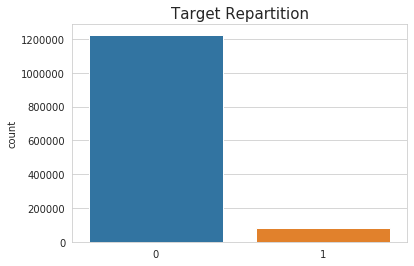

In [68]:
sns.countplot(y_train)
plt.title('Target Repartition', size=15)
plt.show()

# Embedding matrices
- We are using embedding matrices as it has lots of negative words with its vector which can help in predicting unsincere words
- Concatenation of Glove, FastText & Paragram

In [0]:
def make_embed_index(file, word_index, vocab=[], exceptions={}):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == FASTTEXT:
        '''checking for len if it more than 100 for fasttext so we can split at 101 and store in dictionary 'embeddings_index'''
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100 and o.split(" ")[0] in word_index )

    if file == PARAGRAM:
        '''checking for len if it more than 100 for paragram so we can split at 101 and store in dictionary 'embeddings_index'''
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding="utf8", errors='ignore') if len(o)>100 and o.split(" ")[0] in word_index)
    
    else: #GloVe
        '''checking for space for fasttext so we can split at space and store in dictionary 'embeddings_index'''
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if o.split(" ")[0] in word_index)
    

    '''trying to compare the word in the embedding files  with the word in vocab in various ways like checking by converting 
    into capital letter and small letter'''
    for word in vocab:
        try:
            _ = embeddings_index[word]
        except:
            try:
                embeddings_index[word] = embeddings_index[word.lower()]
            except:
                try:
                    embeddings_index[word] = embeddings_index[word.upper()]
                except:
                    try:
                        embeddings_index[word] = embeddings_index[word[0].upper() + word[1:].lower()]
                    except:
                        pass
            
    return embeddings_index

In [0]:
''' Finaly stacking all the word and its vector into a np array and using its mean and standard deviation to shape the matrix'''
'''Finally we get matrix of the embedded files where each word has its vector form'''

def make_embed_mat(embeddings_index):
    all_embs = np.stack(embeddings_index.values())   

    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (len(word_index)+1, embed_size))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [75]:
%%time
glove_index = make_embed_index(GLOVE, word_index, word_count)
glove_index

CPU times: user 39.6 s, sys: 2.21 s, total: 41.8 s
Wall time: 42.9 s


In [76]:
len(glove_index)

197967

In [82]:
len(para_index)

151241

In [83]:
len(fasttext_index)

181063

In [87]:
len(embed_concat)

266048

In [81]:

%%time
fasttext_index = make_embed_index(FASTTEXT, word_index, word_count)

CPU times: user 41.4 s, sys: 1.81 s, total: 43.2 s
Wall time: 43.3 s


In [80]:
%%time
para_index = make_embed_index(PARAGRAM, word_index,word_count)

CPU times: user 29.4 s, sys: 1.72 s, total: 31.1 s
Wall time: 32 s


In [0]:
embed_concat = np.concatenate((make_embed_mat(fasttext_index), make_embed_mat(glove_index), make_embed_mat(para_index)), axis=1)

In [86]:
t_init = time.time()
print(f"Initialized in {(t_init - begin) // 60} minutes")

Initialized in 36.0 minutes


# Modeling

## Tools

### Noise

In [0]:
'''Creating some noise in the model so that the model do not memorize the data and make generalizes weights and become robust to outliers'''
class Noise(nn.Module):
    def __init__(self, mean=0.0, stddev=0.1):
        super(Noise, self).__init__()
        self.mean = mean
        self.stddev = stddev

    def forward(self, input):
        noise = input.clone().normal_(self.mean, self.stddev)
        return input + noise

### Attention Layer



In [0]:
#https://medium.com/intel-student-ambassadors/implementing-attention-models-in-pytorch-f947034b3e66
'''Creating a attention function to focus on specific and important inputs''' 

class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.supports_masking = True
        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = self.step_dim
        eij = torch.mm(x.contiguous().view(-1, feature_dim), self.weight).view(-1, step_dim)
        if self.bias:
            eij = eij + self.b  
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        if mask is not None: 
            a = a * mask
        a = a / torch.sum(a, 1, keepdim=True) + 1e-10
        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

## Model

In [0]:
''' I used model -LSTM+GRU+AttentionLayer(LSTM)+AttentionLayer(GRU)+Dropout(0.1)+avg_pool1(LSTM)+avg_pool1(GRU)+max_pool(lstm)+max_pool(GRU) '''
class Model(nn.Module):
    def __init__(self, embedding_matrix):
        super(Model, self).__init__()
        
        h1 = 64
        h2 = 32
        hd = 32
        
        self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.noise = Noise(stddev=0.05)
        
        self.lstm = nn.LSTM(embedding_matrix.shape[1], 2*h1, bidirectional=False, batch_first=True)
        self.gru = nn.GRU(2*h1, 2*h2, bidirectional=False, batch_first=True)
        
        self.lstm_att = Attention(2*h1, max_len)
        self.gru_att = Attention(2*h2, max_len)
        
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(6*(h1+h2) + nb_features, hd)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(hd, momentum=0.5)
        self.out = nn.Linear(hd, 1)
    
    def forward(self, x):
        embed = self.embedding(x[0])
        
        if self.training:
            embed = torch.squeeze(self.noise(torch.unsqueeze(embed, 0)))
        
        lstm, _ = self.lstm(embed)
        gru, _ = self.gru(lstm)
        
        att1 = self.lstm_att(lstm)
        att2 = self.gru_att(gru)
        
        avg_pool1 = torch.mean(lstm, 1)
        avg_pool2 = torch.mean(gru, 1)
        max_pool1, _ = torch.max(lstm, 1)
        max_pool2, _ = torch.max(gru, 1)
        
        conc = torch.cat((att1, avg_pool1, max_pool1, att2, avg_pool2, max_pool2, x[1]), 1)
        conc = self.dropout(conc)
        conc = self.bn(self.relu(self.linear(conc)))
        conc = self.dropout(conc)
        out = self.out(conc)
        
        return out

# Training

### Sigmoid

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Learning rate

In [0]:
def get_lr(epoch):
    if epoch <= 3:
        return 0.001
    else:
        return 0.0005

### Learning curves

In [0]:
def plot_history(history, title='Learning Curves'):
    plt.plot(history['loss'], label='Train loss')
    try : plt.plot(history['val_loss'], label='Test loss')
    except: pass
    plt.title(title, size=15)
    plt.legend()

### Tweak Threshold

In [0]:
def tweak_threshold(train_preds, y_train):
    tmp = [0,0,0] # idx, cur, max
    delta = 0
    for tmp[0] in np.arange(0.1, 0.501, 0.01):
        tmp[1] = f1_score(y_train, np.array(train_preds)>tmp[0])
        if tmp[1] > tmp[2]:
            delta = tmp[0]
            tmp[2] = tmp[1]
    return tmp[2], delta

### Predict

In [0]:
#https://www.programcreek.com/python/example/100894/torch.utils.data.TensorDataset
''' We are using cuda to efficiently use GPU to speed up'''
def predict(X, f,model, batch_size=1024):
    y = np.array([])
    X = torch.tensor(X, dtype=torch.long).cuda()
    f = torch.tensor(f, dtype=torch.float32).cuda()
    Xf = torch.utils.data.TensorDataset(X, f)
    loader = torch.utils.data.DataLoader(Xf, batch_size=batch_size, shuffle=False)
    for i, (x, f) in enumerate(loader):
        y = np.concatenate((y, sigmoid(model([x, f]).detach().cpu().numpy())[:, 0]))
    return y

### Fitting

In [0]:
def fit(model, X_train, f_train, y_train, X_val=None, f_val=None, y_val=None, epochs=5, batch_size=512):
    history = {"loss":[], "val_loss": []}
    best_loss = 10
    model.cuda()
    
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='sum')
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        
    X_train = torch.tensor(X_train, dtype=torch.long).cuda()
    f_train = torch.tensor(f_train, dtype=torch.float32).cuda()
    y_train = torch.tensor(y_train[:, np.newaxis], dtype=torch.float32).cuda()
    train = torch.utils.data.TensorDataset(X_train, f_train, y_train)    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    
    X_val = torch.tensor(X_val, dtype=torch.long).cuda()
    f_val = torch.tensor(f_val, dtype=torch.float32).cuda()
    y_val = torch.tensor(y_val[:, np.newaxis], dtype=torch.float32).cuda()
    val = torch.utils.data.TensorDataset(X_val, f_val, y_val)
    val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        start_time = time.time()  
            
        lr = get_lr(epoch)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        for x_batch, f_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model([x_batch, f_batch])
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / X_train.shape[0]
    
        model.eval()
        avg_val_loss = 0.
        for i, (x_batch, f_batch, y_batch) in enumerate(val_loader):
            y_pred = model([x_batch, f_batch]).detach()
            avg_val_loss += loss_fn(y_pred, y_batch).item() / X_val.shape[0]
        
        history['loss'].append(avg_loss)
        history['val_loss'].append(avg_val_loss)
        elapsed_time = time.time() - start_time 
        print('Epoch {}/{} \t lr={} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(epoch + 1, epochs, lr, avg_loss, avg_val_loss, elapsed_time))
        
    return history

### $k$-fold

In [0]:
def k_fold(model_class, embedding_matrix, X, f, y, X_test, f_test, k=5, batch_size=512, epochs=5, seed=seed):
    splits = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=420).split(X, y))
    pred_test = np.zeros(X_test.shape[0])
    pred_oof = np.zeros(y.shape[0])
    histories = []
    
    for i, (train_idx, val_idx) in enumerate(splits):
        print(f"-------------   Fold {i+1}  ------------- \n")
        seed_everything(seed + i)
        
        cp_path = f"{i}_weights.pth.tar"
        start_time = time.time()
        
        model = model_class(embedding_matrix)

        history = fit(model, X[train_idx], f[train_idx], y[train_idx], X[val_idx], f[val_idx], y[val_idx], epochs=epochs, batch_size=batch_size)
        histories.append(history)

        pred_oof[val_idx] = predict(X[val_idx], f[val_idx], model)
        pred_test += predict(X_test, f_test, model) / k
        
        score, threshold = tweak_threshold(pred_oof[val_idx], y[val_idx])
        
        print(f"\n Scored {score :.4f} for threshold {threshold :.3f} on validation data")
        print(f"\n    Done in {(time.time() - start_time) / 60 :.1f} minutes \n")
        
    return pred_test, pred_oof, histories

## Training

In [99]:
pred_test, pred_oof, histories = k_fold(Model, embed_concat, 
                                        X_train, features_train, y_train, X_test, features_test,
                                        k=5, batch_size=512, epochs=4)

-------------   Fold 1  ------------- 

Epoch 1/4 	 lr=0.001 	 loss=0.1509 	 val_loss=0.1016 	 time=90.67s
Epoch 2/4 	 lr=0.001 	 loss=0.0998 	 val_loss=0.0972 	 time=90.14s
Epoch 3/4 	 lr=0.001 	 loss=0.0920 	 val_loss=0.0963 	 time=90.14s
Epoch 4/4 	 lr=0.001 	 loss=0.0850 	 val_loss=0.0969 	 time=90.27s

 Scored 0.6863 for threshold 0.310 on validation data

    Done in 6.4 minutes 

-------------   Fold 2  ------------- 

Epoch 1/4 	 lr=0.001 	 loss=0.1471 	 val_loss=0.1023 	 time=90.84s
Epoch 2/4 	 lr=0.001 	 loss=0.0987 	 val_loss=0.0973 	 time=90.50s
Epoch 3/4 	 lr=0.001 	 loss=0.0906 	 val_loss=0.0965 	 time=90.60s
Epoch 4/4 	 lr=0.001 	 loss=0.0834 	 val_loss=0.0977 	 time=90.78s

 Scored 0.6883 for threshold 0.330 on validation data

    Done in 6.4 minutes 

-------------   Fold 3  ------------- 

Epoch 1/4 	 lr=0.001 	 loss=0.1479 	 val_loss=0.1004 	 time=90.98s
Epoch 2/4 	 lr=0.001 	 loss=0.0990 	 val_loss=0.0985 	 time=90.50s
Epoch 3/4 	 lr=0.001 	 loss=0.0910 	 val_loss=

In [100]:
score, threshold = tweak_threshold(pred_oof, y_train)
print(f"Local CV : {score:.4f} for threshold {threshold:.3f}")

Local CV : 0.6866 for threshold 0.310


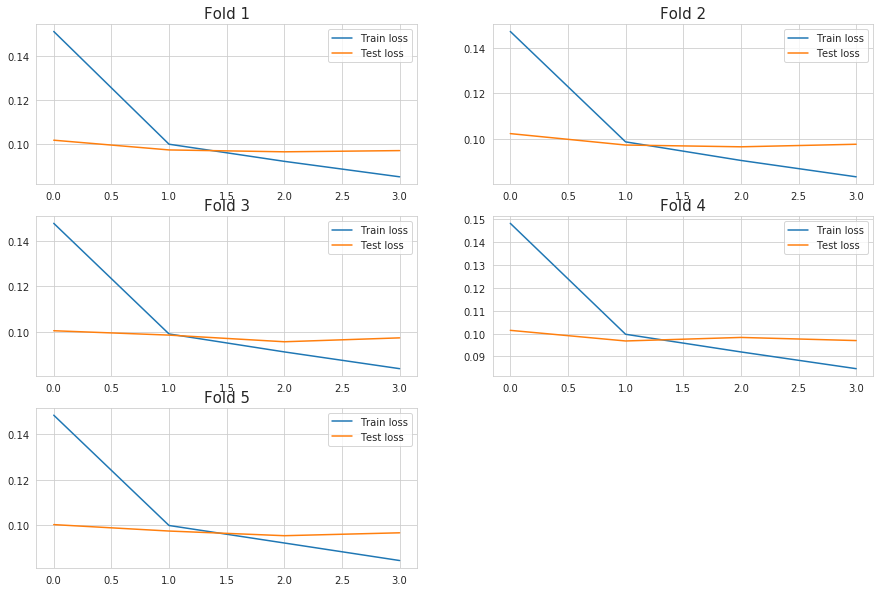

In [101]:
plt.figure(figsize=(15, 10))
for i in range(len(histories)):
    plt.subplot(3, 2, i+1)
    plot_history(histories[i], "Fold " + str(i+1))
plt.show()

# Submission

In [0]:
label_test = (pred_test > threshold).astype(int)

In [0]:
output = pd.DataFrame({"qid": test_df["qid"].values})
output['prediction'] = label_test
output.to_csv("submission.csv", index=False)

In [114]:
output.head()

,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
